# Machine Learning Model

## Imports

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
palette = 'mako'

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, max_error, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LearningCurveDisplay, KFold

from sklearn.feature_selection import SelectKBest, f_classif

from keras import models, layers

# Tratamento inicial

In [134]:
df = pd.read_pickle('../datasets/processed.pkl')
df.drop(columns = ['data', 'segundos_depois_meia_noite'], inplace = True)
df.sample(5)

,consumo_energia,corrente_atrasada,corrente_principal,co2,potencia_atrasado,potencia_principal,estado_semana,dia_semana,tipo_carga
25918,2.77,5.26,0.0,0.000000,46.60,100.0,Dia da Semana,Quinta-feira,Carga leve
6669,30.10,15.55,0.0,0.010002,88.84,100.0,Final de Semana,Domingo,Carga maxima
14904,2.92,5.76,0.0,0.000000,45.22,100.0,Dia da Semana,Terca-feira,Carga leve
28644,121.18,56.12,0.0,0.059998,90.74,100.0,Dia da Semana,Sexta-feira,Carga media
27726,61.16,47.92,0.0,0.029999,78.72,100.0,Dia da Semana,Terca-feira,Carga media


In [135]:
df.estado_semana = LabelEncoder().fit_transform(df.estado_semana)

# Testes de modelos

In [136]:
features = df.drop(columns = ['consumo_energia', 'potencia_principal', 'co2'])
target = df.consumo_energia

In [137]:
def create_model(features: pd.DataFrame, model) -> Pipeline:
    numerical = features.select_dtypes(include='number').columns.to_list()
    categorical = features.select_dtypes(include='category').columns.to_list()
    
    cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])
    num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    transformers = [('num', num_transformer, numerical), ('cat', cat_transformer, categorical)]
    
    preprocessor = ColumnTransformer(transformers=transformers)
    
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ("model", model)
    ])

In [138]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=777)

In [139]:
def create_scores(model_list: dict, train_x: pd.DataFrame, train_y: pd.Series, test_x: pd.DataFrame, test_y: pd.Series) -> pd.DataFrame:
    scores = {
        'Algorithm': [],
        'Type': [],
        'R2': [],
        'Max Error': [],
        'Mean Absolute Error': [],
        'Mean Squared Error': []
    }
    
    for algorithm, the_model in model_list.items():
        for item in ['Train', 'Test']:
            model = the_model
            model.fit(train_x, train_y)
            
            if item == 'Train':
                pred_y = model.predict(train_x)
                scores['Type'].append('Train')
                target = train_y
            else:
                pred_y = model.predict(test_x)
                scores['Type'].append('Test')
                target = test_y
                
            scores['Algorithm'].append(algorithm)
            scores['R2'].append( round( r2_score(target, pred_y), 2) )
            scores['Max Error'].append( round( max_error(target, pred_y), 2) )
            scores['Mean Absolute Error'].append( round( mae(target, pred_y), 2) )
            scores['Mean Squared Error'].append( round( mse(target, pred_y), 2) )

    return pd.DataFrame(scores)

In [140]:
def create_learning_curves(model_list: dict, features: pd.DataFrame, target: pd.Series, n_row = 2, n_col = 2) -> None:
    fig = plt.figure(figsize=(12, 7))
    for i, (algorithm, model_) in enumerate(model_list.items()):
        ax = fig.add_subplot(n_row, n_col, i + 1)
        plt.title(f"{algorithm}", fontsize='large', fontweight='bold')
        plt.grid(visible=True, color='black', linewidth=.25)
        plt.xlabel("Number of Samples")
        plt.ylabel("R2 score")
        LearningCurveDisplay.from_estimator(model_, features, target, score_type='both', ax=ax, cv=5, scoring='r2', n_jobs=-1, random_state=777)
    fig.tight_layout()

In [141]:
def create_plot(results: pd.DataFrame, n_rows = 2, n_cols = 2, rot=45) -> None:
    fig = plt.figure(figsize=(16, 10))
    for i, title in enumerate(results.columns[2:]):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.barplot(data=results, x='Algorithm', y=title, hue='Type', palette=palette, ax=ax)
        for value in ax.containers:
            ax.bar_label(value)
        ax.tick_params(axis='x', labelrotation=rot, size=12)
        ax.tick_params(axis='y', size=12)
        ax.set(ylabel=None, xlabel=None)
        ax.set_title(f"{title.capitalize()}", fontsize='large', fontweight='bold', 
                style='italic', family='monospace')
        ax.grid(visible=True, color='black', linewidth=.25)
    fig.tight_layout()

In [142]:
def cross_validation(model, model_name: str, features: pd.DataFrame, target: pd.Series, cv=5) -> pd.DataFrame:
    kf = KFold(n_splits=cv)
    scores = {
        'model': model_name,
        'train_score': [],
        'test_score': [],
        'train_mae': [],
        'test_mae': [],
    }

    for train_index, test_index in kf.split(features):
        train_x, train_y = features.iloc[train_index], target.iloc[train_index]
        test_x, test_y = features.iloc[test_index], target.iloc[test_index]
        
        new_model = model
        new_model.fit(train_x, train_y)

        pred_train_y = new_model.predict(train_x)
        pred_test_y = new_model.predict(test_x)

        scores['train_score'].append( r2_score(train_y, pred_train_y) )
        scores['test_score'].append( r2_score(test_y, pred_test_y) )
        scores['train_mae'].append( mae(train_y, pred_train_y) )
        scores['test_mae'].append( mae(test_y, pred_test_y) )
    
    return pd.DataFrame(scores)

In [143]:
def plot_validation_curve(results: list, title: list, type: str, n_row=2, n_col=2) -> None:
    fig = plt.figure(figsize=(12, 7))
    for i, item in enumerate(results):
        ax = fig.add_subplot(n_row, n_col, i + 1)
        x = np.arange(item.shape[0])
        
        if type == 'r2':
            metric_train = 'train_score'
            metric_test = 'test_score'
        else:
            metric_train = 'train_mae'
            metric_test = 'test_mae'
        
        if item[metric_train].max() < item[metric_test].max(): max = item[metric_test].max()
        else: max = item[metric_train].max()
        if item[metric_train].min() > item[metric_test].min(): min = item[metric_test].min()
        else: min = item[metric_train].min()
            
        min = round(min, 1)
        max = round(max, 1)
        
        sns.lineplot(data=item, x=x, y=metric_train, label='Training Scores', marker= 'o', markersize=5, ax=ax)
        sns.lineplot(data=item, x=x, y=metric_test, label='Testing Scores', marker= 'o', markersize=5, ax=ax)

        if type == 'r2':
            ax.set(ylabel='R2 Score')
        else:
            ax.set(ylabel='MAE Score')
        ax.grid(visible=True, color='black', linewidth=.5)
        ax.set_title(title[i])
        ax.set_ylim(min-0.1, max+0.1)
    fig.tight_layout()

In [144]:
model_list = {
    'Linear Regression': create_model(features, LinearRegression()),
    'KNeighbors Regressor': create_model(features, KNeighborsRegressor()),
    'Decision Tree Regressor': create_model(features, DecisionTreeRegressor(random_state=777)),
    'Random Forest Regressor': create_model(features, RandomForestRegressor(random_state=777, n_jobs=-1)),
}

In [145]:
scores = create_scores(model_list, x_train, y_train, x_test, y_test)

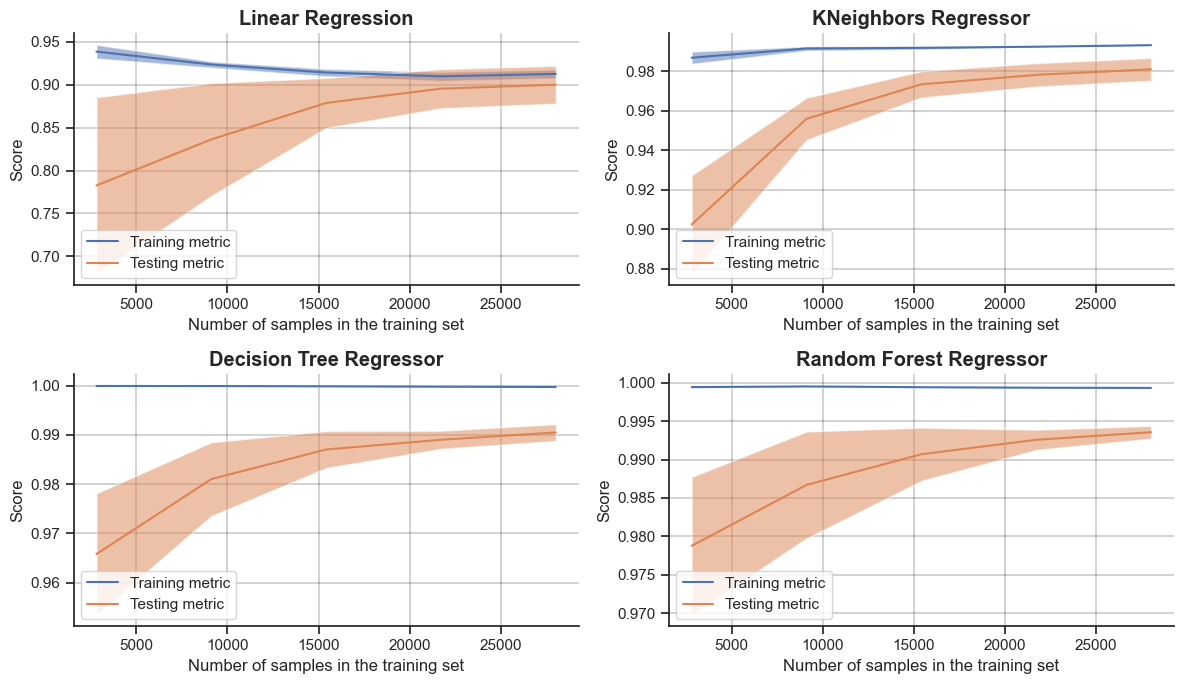

In [146]:
create_learning_curves(model_list, features, target)
plt.show()

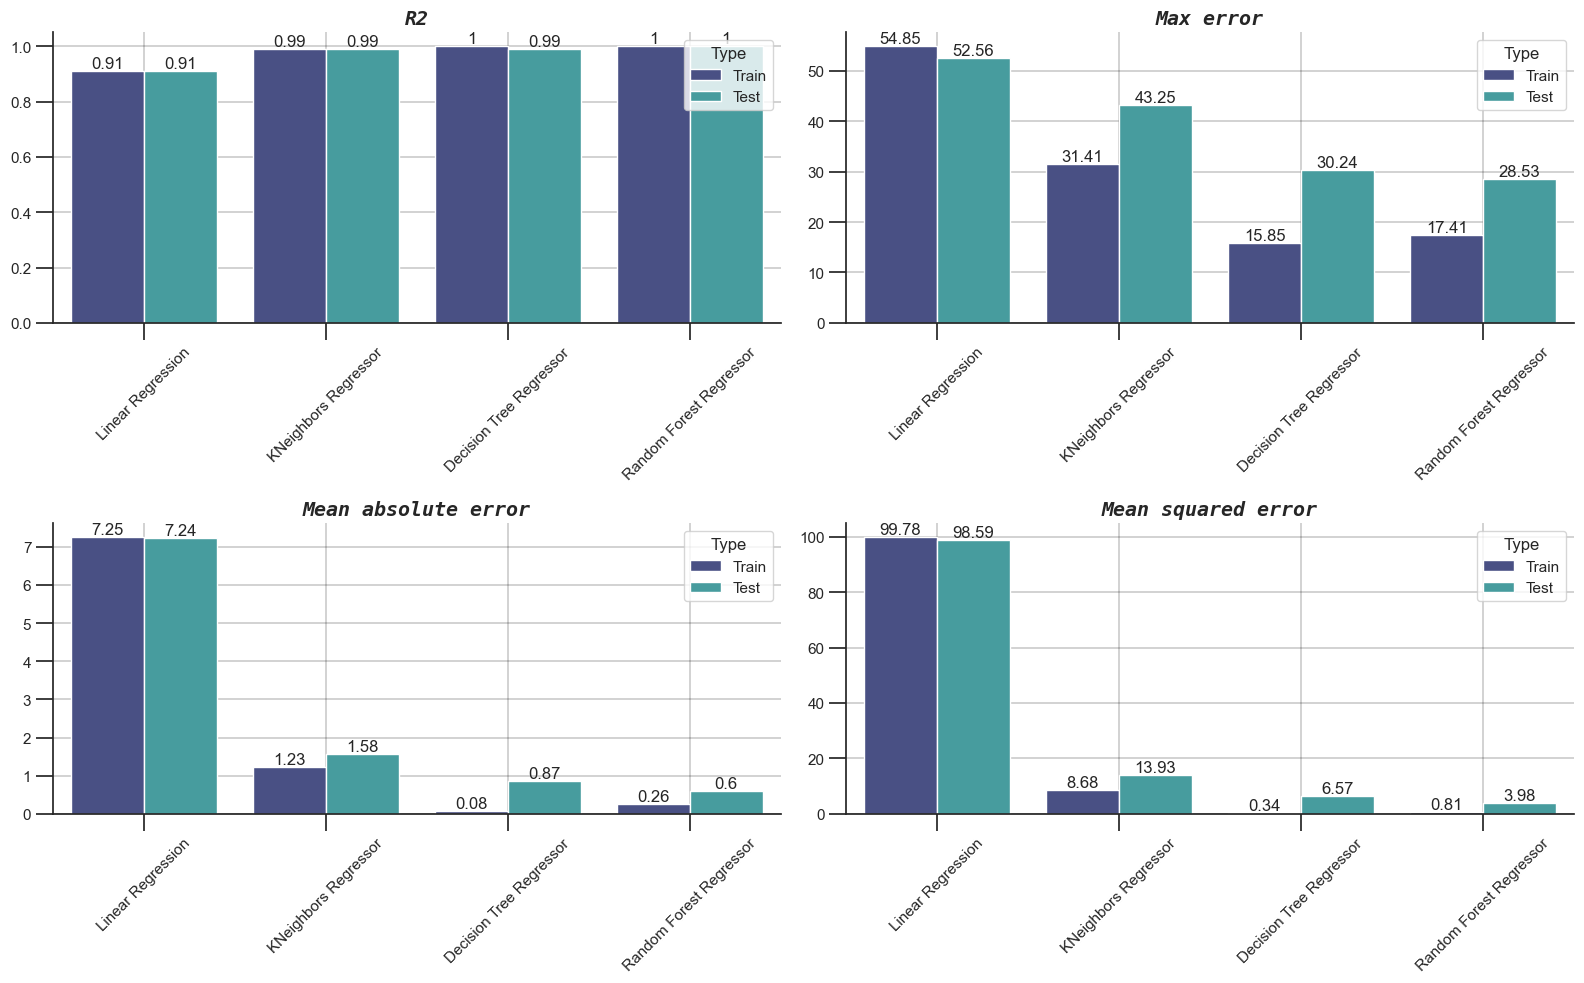

In [147]:
create_plot(scores)
plt.show()

In [148]:
model_results = [cross_validation(model, model_name, features, target, cv=10) for model_name, model in model_list.items()]

In [149]:
pd.DataFrame(pd.concat(model_results, ignore_index=True)).groupby('model').mean()

,train_score,test_score,train_mae,test_mae
model,,,,
Decision Tree Regressor,0.999674,0.991416,0.083519,1.038800
KNeighbors Regressor,0.993312,0.984089,1.123656,1.810801
Linear Regression,0.911440,0.904987,7.233450,7.554116
Random Forest Regressor,0.999297,0.994240,0.247647,0.749302


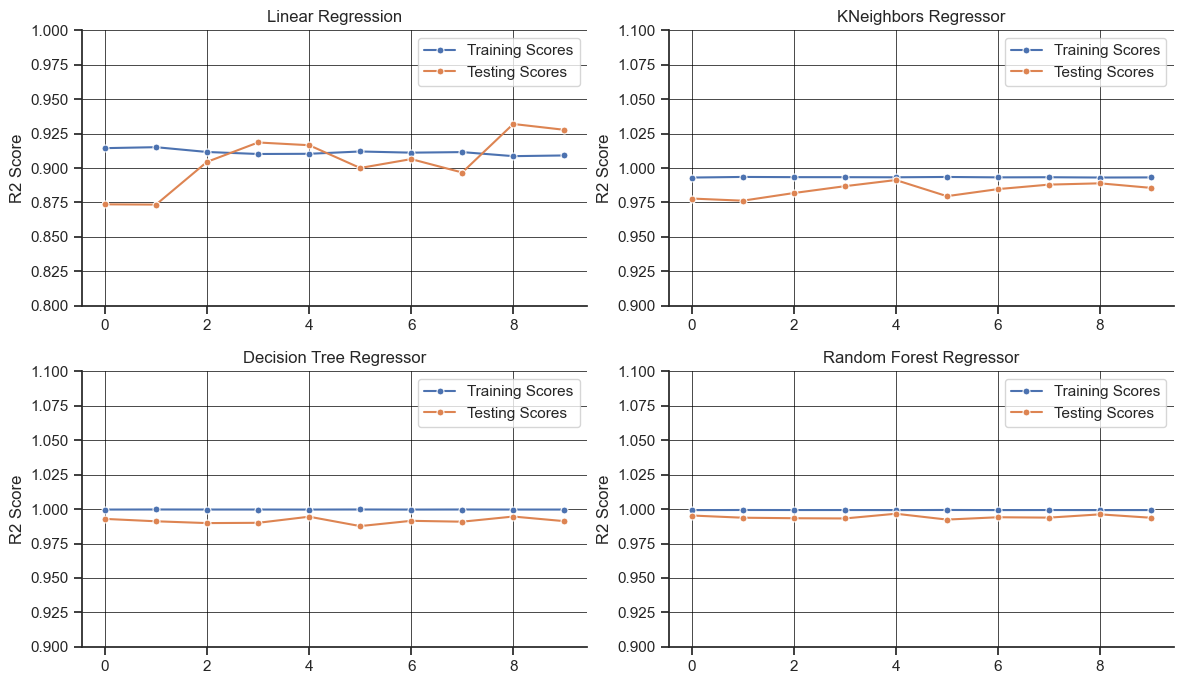

In [150]:
plot_validation_curve(model_results, list(model_list.keys()), 'r2')
plt.show()

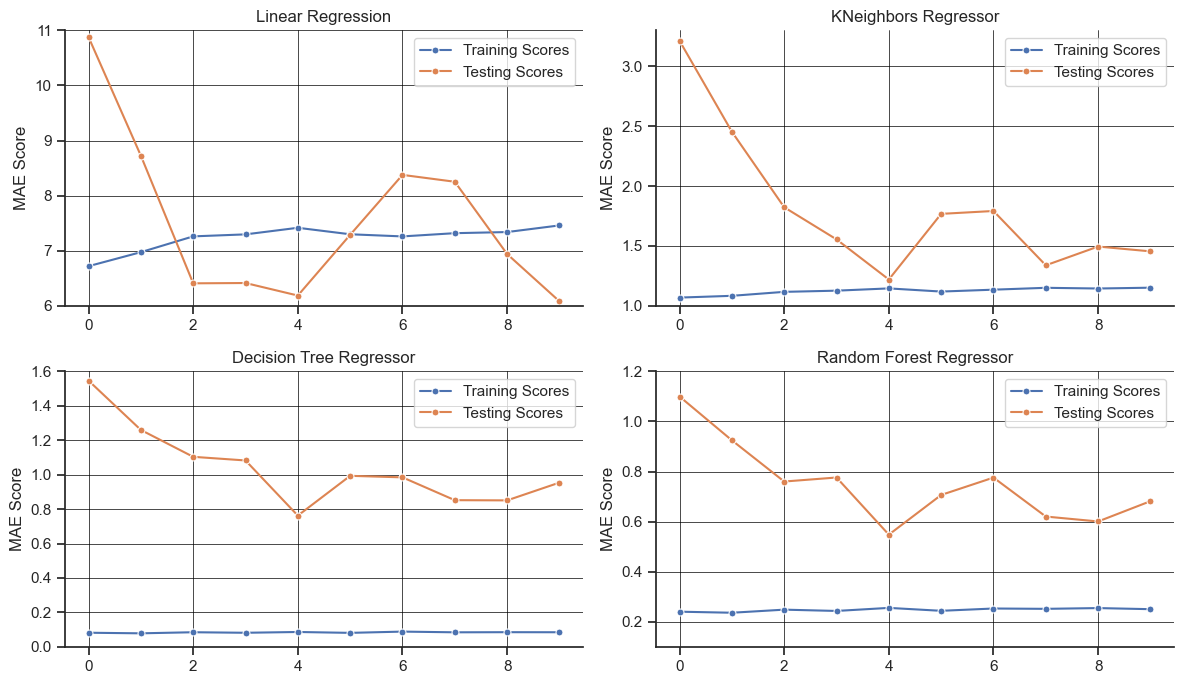

In [151]:
plot_validation_curve(model_results, list(model_list.keys()), 'mae')
plt.show()

## Tunagem de hiperparâmetros

In [152]:
# features_grid = features.copy()

# numerical = features_grid.select_dtypes(include='number').columns
# categorical = features_grid.select_dtypes(include='category').columns

# features_grid[numerical] = StandardScaler().fit_transform(features_grid[numerical])
# features_grid = pd.get_dummies(features_grid, columns=categorical, drop_first=True)

In [153]:
# param_grid = {
#     'copy_X': [True, False],
#     'fit_intercept': [True, False],
#     'positive': [True, False]
# }

# grid = GridSearchCV(LinearRegression(), param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
# grid.fit(features_grid, target)
# grid.best_params_

In [154]:
# param_grid = {
#     'n_neighbors': np.arange(1, 10),
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
# }

# grid = GridSearchCV(KNeighborsRegressor(), param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
# grid.fit(features_grid, target)
# grid.best_params_

In [155]:
# param_grid={
#     'max_depth': np.arange(1, 10),
#     'min_samples_split': np.arange(2, 10),
#     'min_samples_leaf': np.arange(1, 10),
#     'max_features': ['sqrt', 'log2'],
# }

# grid = GridSearchCV(DecisionTreeRegressor(random_state=777), param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
# grid.fit(features_grid, target)
# grid.best_params_

In [156]:
# param_grid = {
#     'max_depth': np.arange(1, 10),
#     'min_samples_split': np.arange(2, 10),
#     'min_samples_leaf': np.arange(1, 10),
#     'max_features': ['sqrt', 'log2'],
#     'n_estimators': np.arange(100, 600, 100)
# }

# grid = GridSearchCV(RandomForestRegressor(random_state=777, n_jobs=-1), param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
# grid.fit(features_grid, target)
# grid.best_params_

# Testes de modelos tunados

In [157]:
model_list = {
    'Linear Regression': create_model(features, LinearRegression(copy_X=True, fit_intercept=True, positive=False)),
    'KNeighbors Regressor': create_model(features, KNeighborsRegressor(algorithm='brute', n_neighbors=3, weights='distance')),
    'Decision Tree Regressor': create_model(features, DecisionTreeRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=3, min_samples_split=9, random_state=777)),
    'Random Forest Regressor': create_model(features, RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=1, min_samples_split=8, n_estimators=400, random_state=777, n_jobs=-1)),
}

In [158]:
scores = create_scores(model_list, x_train, y_train, x_test, y_test)

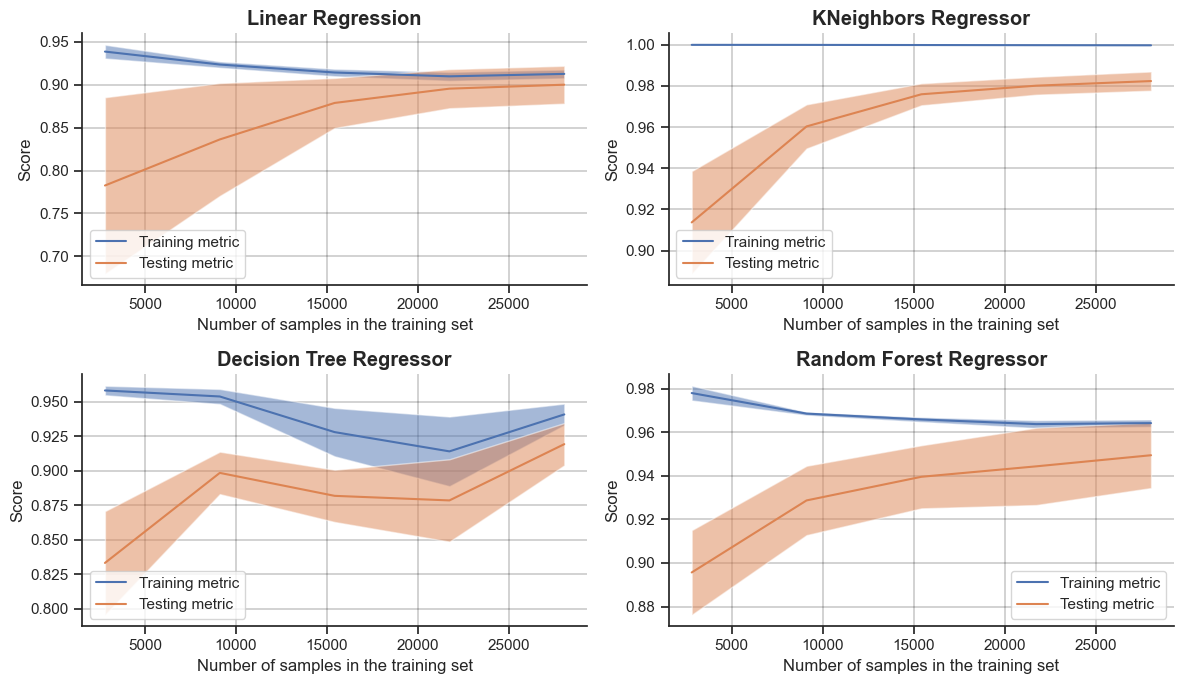

In [159]:
create_learning_curves(model_list, features, target)
plt.show()

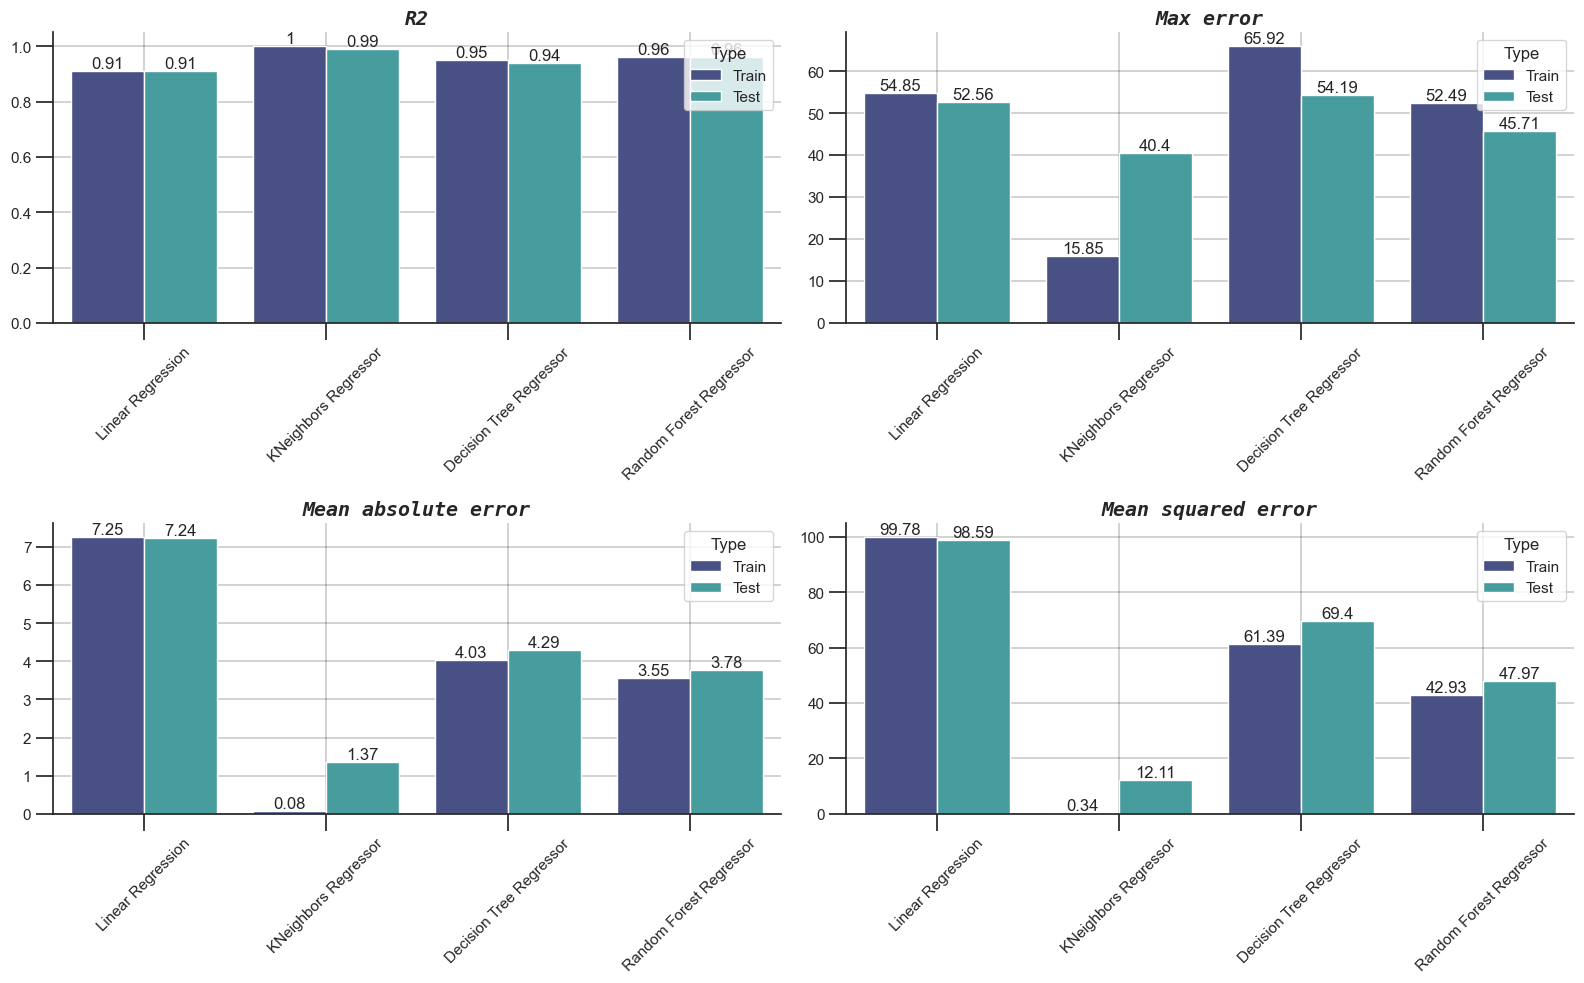

In [160]:
create_plot(scores)
plt.show()

In [161]:
model_results = [cross_validation(model, model_name, features, target, cv=10) for model_name, model in model_list.items()]

In [162]:
pd.DataFrame(pd.concat(model_results, ignore_index=True)).groupby('model').mean()

,train_score,test_score,train_mae,test_mae
model,,,,
Decision Tree Regressor,0.924390,0.901990,4.611238,5.335377
KNeighbors Regressor,0.999664,0.985019,0.088605,1.654770
Linear Regression,0.911440,0.904987,7.233450,7.554116
Random Forest Regressor,0.962759,0.952462,3.489044,4.070118


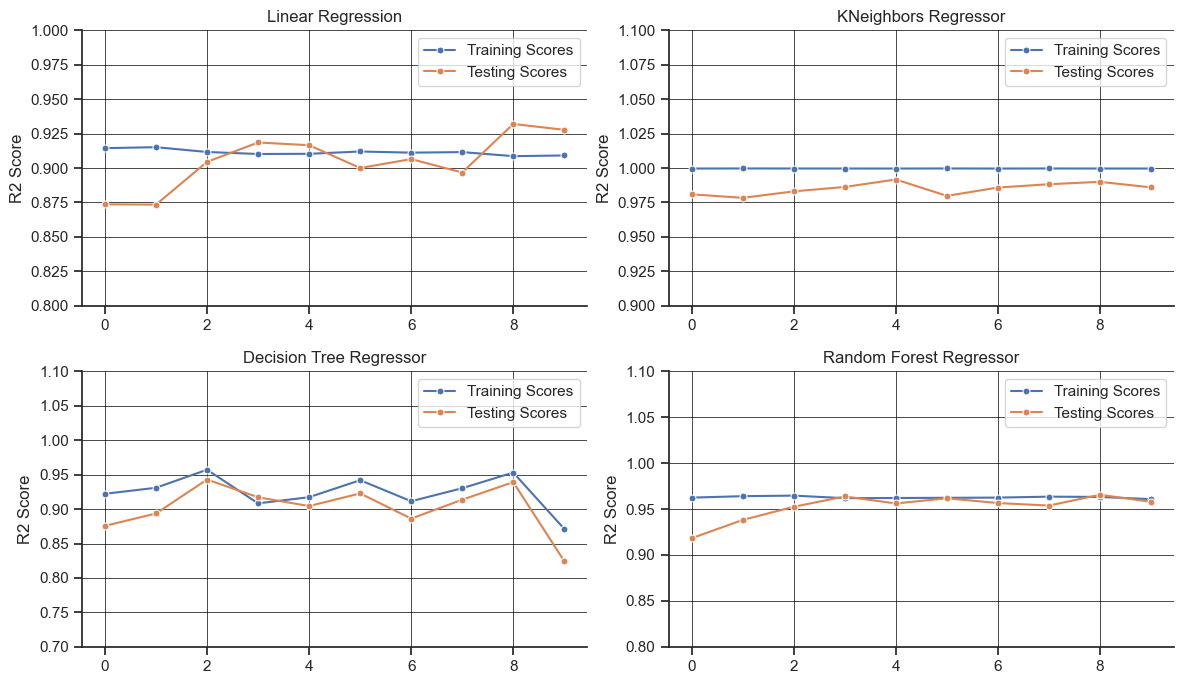

In [163]:
plot_validation_curve(model_results, list(model_list.keys()), 'r2')
plt.show()

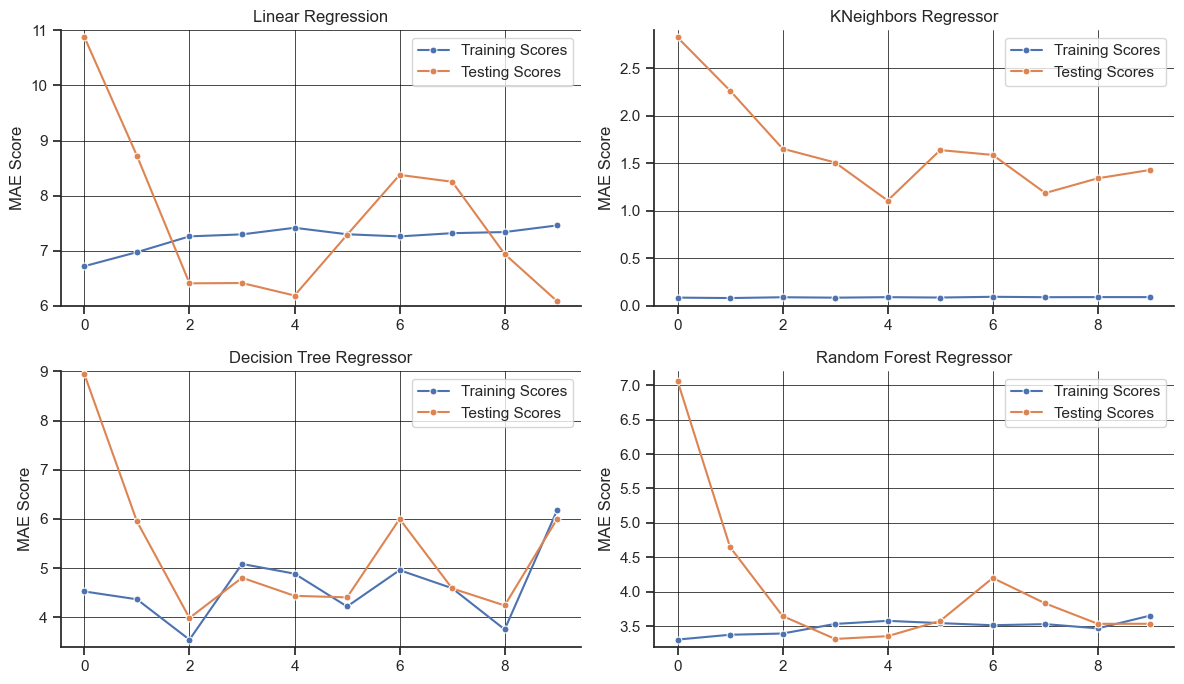

In [164]:
plot_validation_curve(model_results, list(model_list.keys()), 'mae')
plt.show()

# Feature Selection

In [165]:
features = df.drop(columns = ['consumo_energia', 'potencia_principal', 'co2'])

In [166]:
features_test = features.copy()
categorical = features_test.select_dtypes(include='category').columns
for item in categorical:
    features_test[item] = LabelEncoder().fit_transform(features_test[item])

k_best = SelectKBest(score_func=f_classif, k=features.shape[1]-1)

X_k_best = k_best.fit_transform(features_test, target)

columns = pd.DataFrame(X_k_best, columns=features_test.columns[k_best.get_support()]).columns.to_list()
columns

['corrente_atrasada',
 'corrente_principal',
 'potencia_atrasado',
 'estado_semana',
 'tipo_carga']

In [167]:
features = features[columns]

# Testes de modelos tunados com feature selection

In [168]:
model_list = {
    'Linear Regression': create_model(features, LinearRegression(copy_X=True, fit_intercept=True, positive=False)),
    'KNeighbors Regressor': create_model(features, KNeighborsRegressor(algorithm='brute', n_neighbors=3, weights='distance')),
    'Decision Tree Regressor': create_model(features, DecisionTreeRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=3, min_samples_split=9, random_state=777)),
    'Random Forest Regressor': create_model(features, RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=1, min_samples_split=8, n_estimators=400, random_state=777, n_jobs=-1)),
}

In [169]:
model_results = [cross_validation(model, model_name, features, target, cv=10) for model_name, model in model_list.items()]

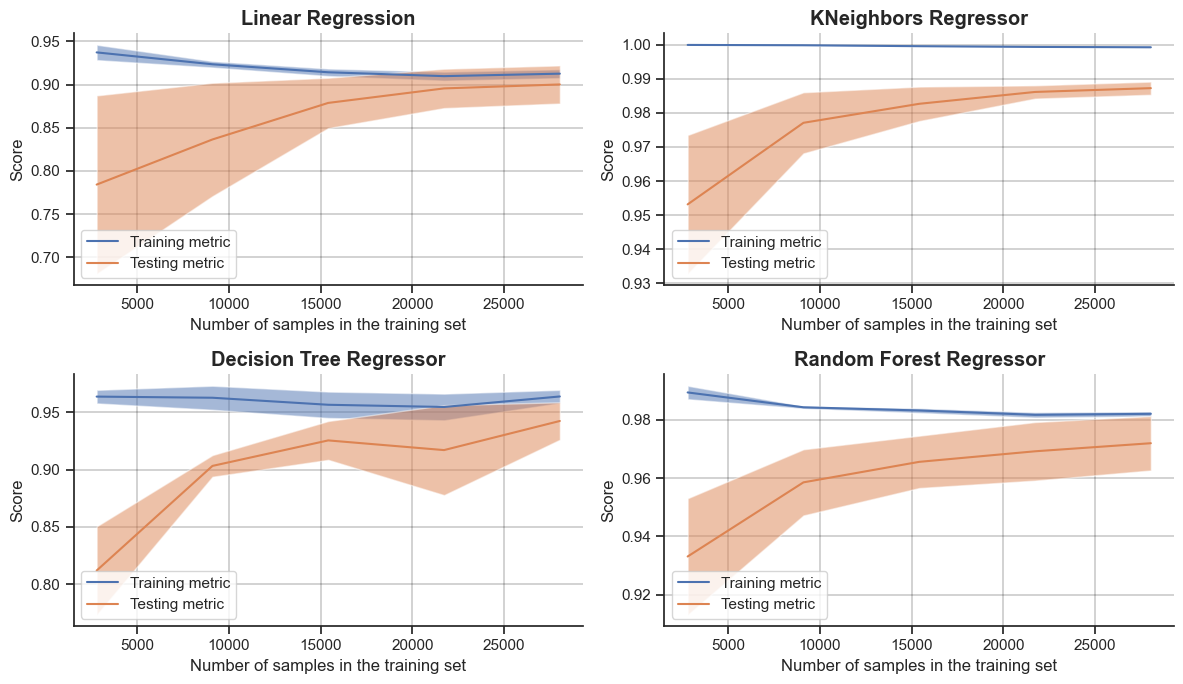

In [170]:
create_learning_curves(model_list, features, target)
plt.show()

In [171]:
scores = create_scores(model_list, x_train, y_train, x_test, y_test)

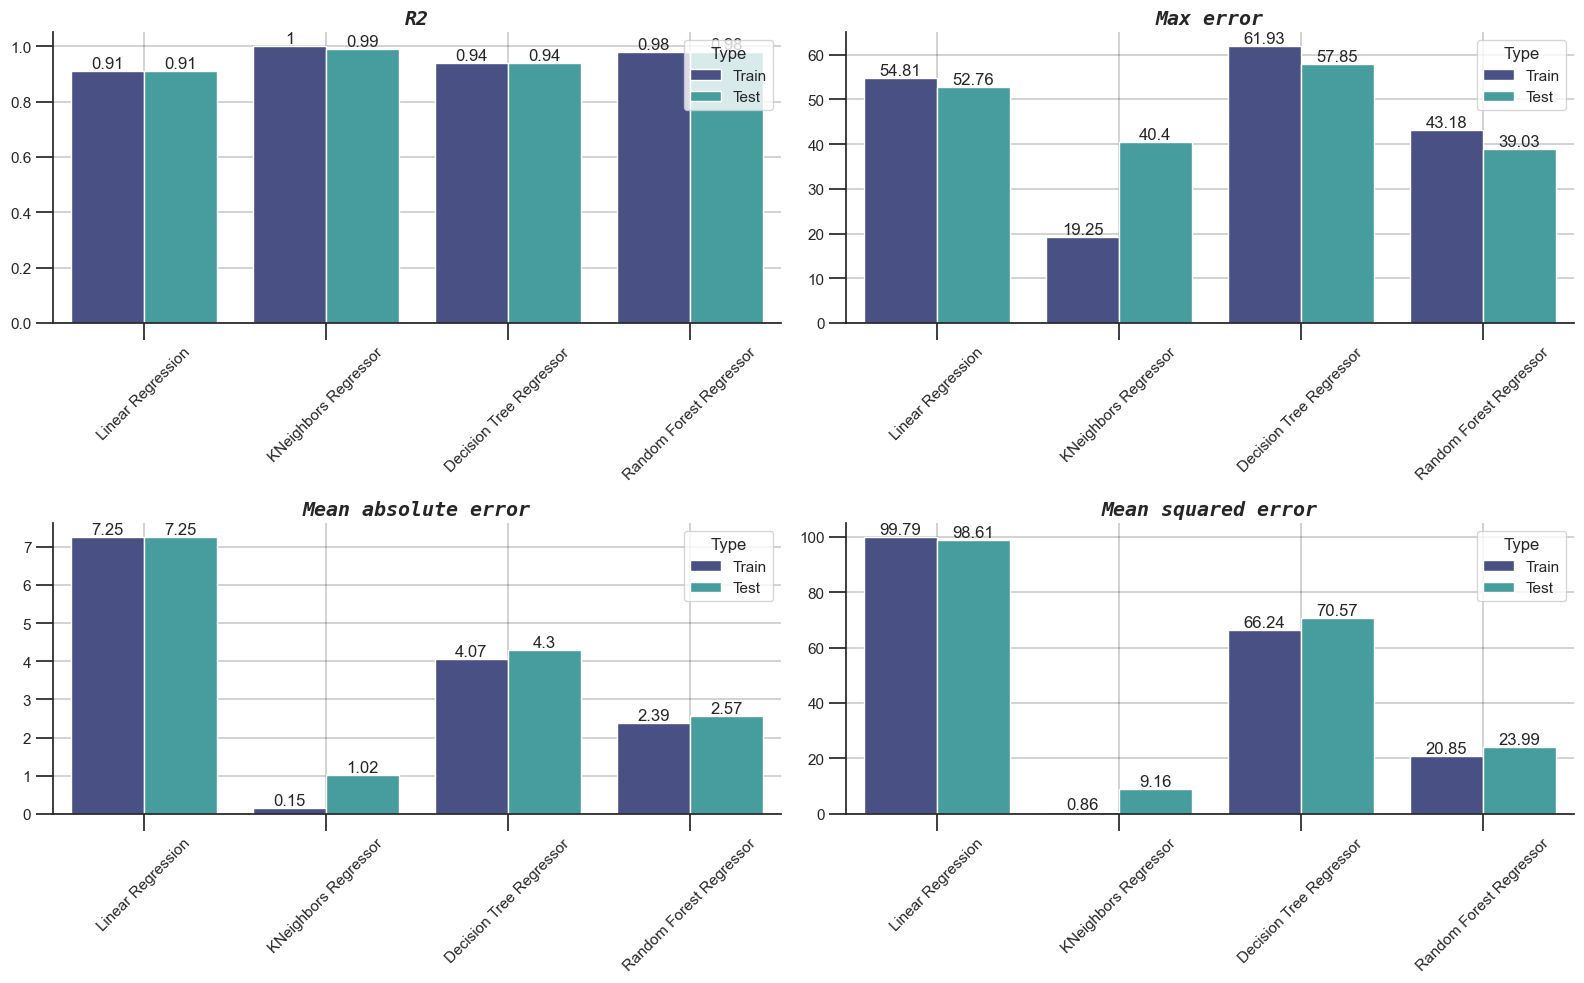

In [172]:
create_plot(scores)
plt.show()

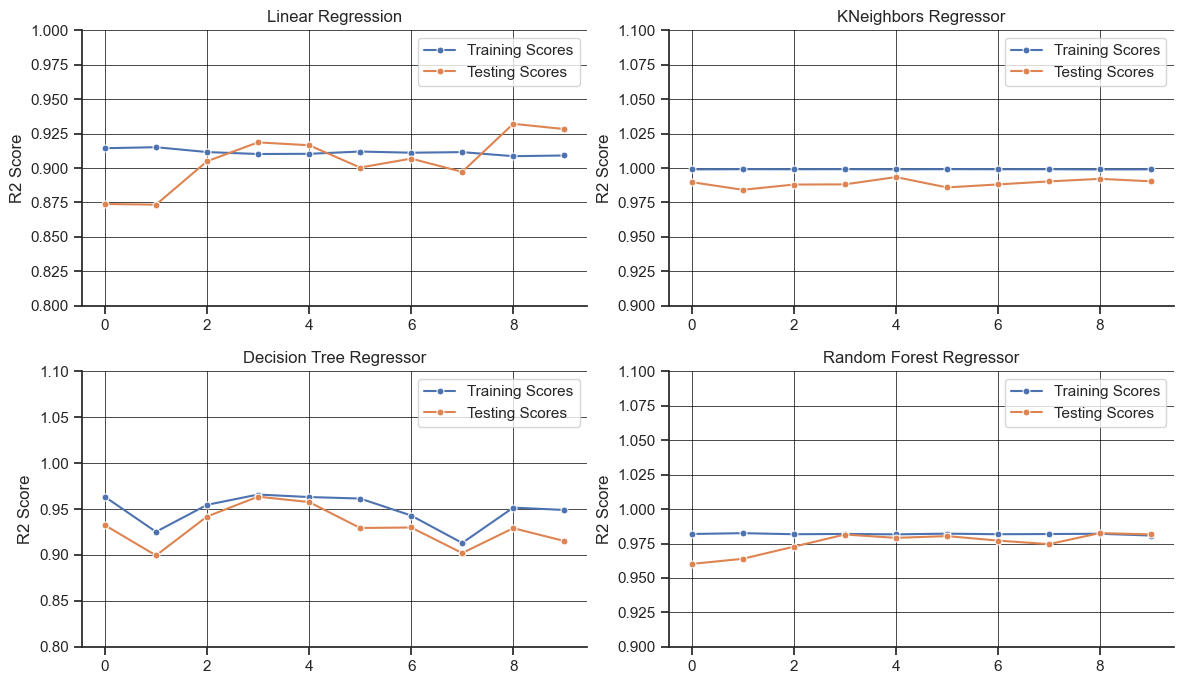

In [173]:
plot_validation_curve(model_results, list(model_list.keys()), 'r2')
plt.show()

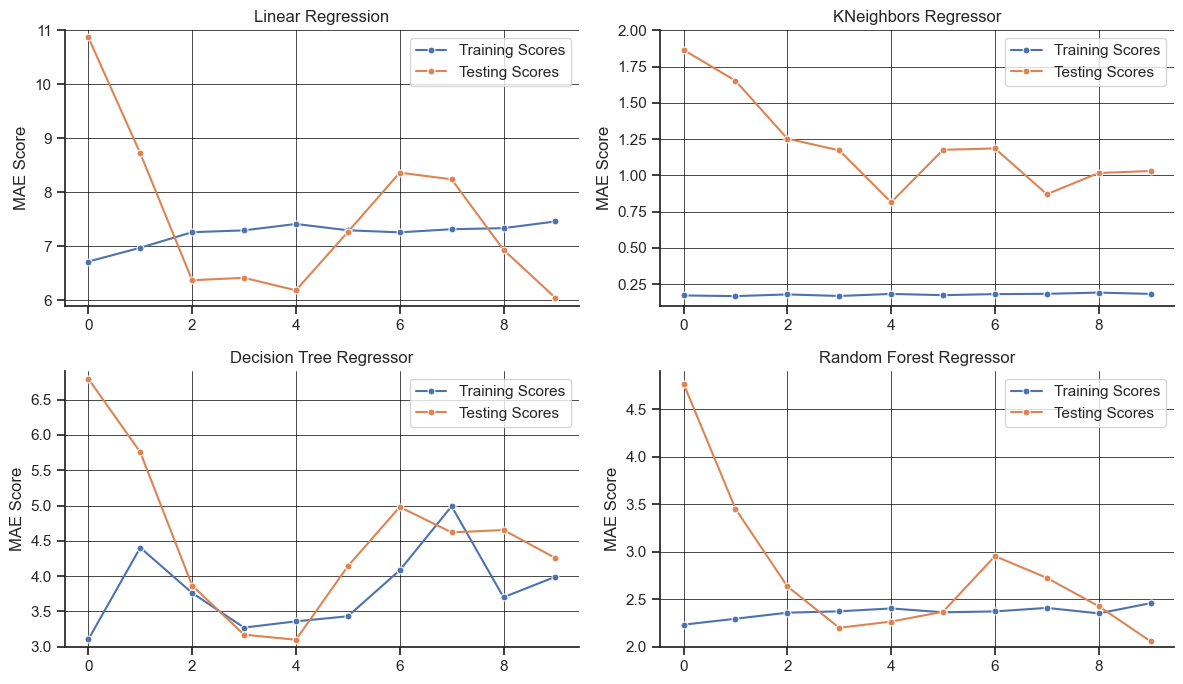

In [174]:
plot_validation_curve(model_results, list(model_list.keys()), 'mae')
plt.show()

# Redes neurais

In [175]:
features = df.drop(columns = ['consumo_energia', 'potencia_principal', 'co2'])
target = df.consumo_energia

features = pd.get_dummies(features, drop_first=True, dtype='int8')

In [176]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=777)

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [177]:
def create_network(len_input: int) -> models.Sequential:
    network = models.Sequential()
    network.add(layers.Dense(30, input_shape=(len_input, ), activation='relu'))
    network.add(layers.Dense(30))
    network.add(layers.Dense(1))
    network.compile(loss="mae", optimizer='Adam', metrics=["mse"])
    return network

model = create_network(features.shape[1])

history = model.fit(x_train_scaled, y_train, epochs=5, verbose=1, batch_size=10, 
                    validation_data=(x_test_scaled, y_test), shuffle=True)
pred_y = model.predict(x_test_scaled)

print(f'Algorithm: MLP')
print(f'R2 score: {r2_score(y_test, pred_y):}',)
print(f'Mean Absolute Error: {mae(y_test, pred_y):}')
print(f'Mean Squared Error: {mse(y_test, pred_y)}')

Epoch 1/5
2453/2453 [==============================] - 2s 663us/step - loss: 5.7400 - mse: 167.5958 - val_loss: 3.4134 - val_mse: 43.0806
Epoch 2/5
2453/2453 [==============================] - 2s 637us/step - loss: 2.9815 - mse: 33.9387 - val_loss: 2.5504 - val_mse: 24.8922
Epoch 3/5
2453/2453 [==============================] - 2s 630us/step - loss: 2.3191 - mse: 22.3636 - val_loss: 2.0459 - val_mse: 17.8478
Epoch 4/5
2453/2453 [==============================] - 2s 633us/step - loss: 1.8928 - mse: 16.2455 - val_loss: 1.7369 - val_mse: 14.1704
Epoch 5/5
329/329 [==============================] - 0s 357us/step
Algorithm: MLP
R2 score: 0.9893834799652155
Mean Absolute Error: 1.5471935073773926
Mean Squared Error: 11.815707489512228


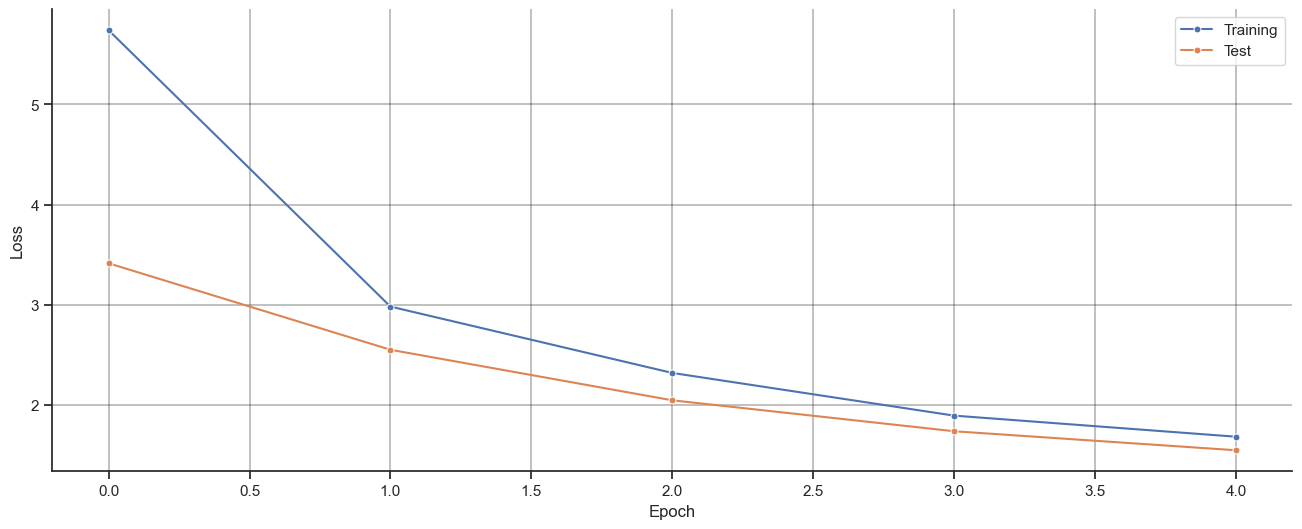

In [178]:
fig, ax = plt.subplots(figsize=(16, 6))

loss = pd.DataFrame({'training_loss': history.history["loss"], 'test_loss': history.history["val_loss"]})

epoch_count = np.arange(loss.shape[0])

sns.lineplot(data=loss, x=epoch_count, y='training_loss', label='Training', marker= '.', markersize=10, ax=ax)
sns.lineplot(data=loss, x=epoch_count, y='test_loss', label='Test', marker= '.', markersize=10, ax=ax)
ax.legend()
ax.set(xlabel='Epoch', ylabel='Loss')
ax.grid(visible=True, color='black', linewidth=.35)
plt.show()